In [1]:
import pandas as pd
from binance.client import Client
import backtrader as bt
import matplotlib.pyplot as plt
import mplfinance as mpf
import itertools
import numpy as np
import seaborn as sns
%matplotlib inline
import yfinance as yf
from sklearn.model_selection import TimeSeriesSplit
import time
from datetime import datetime, timedelta
from itertools import product
import pprint

### Premise on the workflow
This workflow is designed to closely follow my thought process. At points where the code is modified from earlier versions, I explain the reasons behind the changes, including any mistakes identified and room for improvement. This approach aims to provide insight into the development and analysis steps, helping the reader understand why certain adjustments were made. At points it might have been better to simply rewrite the old code, but this would miss the thinking process.

# Momentum + SMA crossover strategy development plan


## 1. Strategy Implementation  

### Momentum strategy  
- Use **momentum indicator** over a lookback window to detect trends  
- Adjust position sizing dynamically based on volatility (ATR) and conviction (momentum strength × volume)  

### SMA Crossover strategy  
- Define **short-term (fast) and long-term (slow) SMAs** as additional signals  
- Generate buy signals when fast SMA crosses above slow SMA  
- Generate sell signals when fast SMA crosses below slow SMA  


## 2. Backtesting engine  
- Use the **Backtrader framework** to simulate historical trades for the different strategies and modifications  
- Feed combined historical data for indicators and price  
- Implement cross-validation
- Collect final portfolio values for performance comparison  


## 3. Performance analysis  
- Calculate key metrics for each strategy and their combinations:  
  - Total return  
  - Sharpe Ratio  
  - Maximum Drawdown  
  - Win Rate (percentage of profitable trades)  
- Compare momentum-only, SMA-only, and combined strategy performance  


## 4. Visualization  
- Plot assets
- Plot price charts with buy/sell markers
- Show equity curves side-by-side to visualize strategy growth over time  




## 5. Parameter optimization and cross validation  
- Perform grid search over key hyperparameters such as:  
  - Momentum lookback window  
  - Momentum threshold  
  - SMA fast and slow periods  
  - ATR period for volatility adjustment  
- Use **cross-validation** with multiple time splits to avoid overfitting  



## 6. Conclusion and Insights  
- Summarize how momentum and SMA crossover strategies individually and jointly perform  
- Discuss when momentum signals are more effective and when SMA crossovers help  
- Reflect on:  
  - Strengths and weaknesses of each approach  
  - Impact of volatility and conviction weighting on position sizing  
  - Future improvements: adding machine learning signals, risk management (e.g., drawdown control), or more complex indicators  


## Initial model

We will start small. We are going to begin by implementing a very basic momentum trading strategy and then go ahead from there.
- If the price has gone up a lot over the last $N$ days, we buy
- If the price has dropped over the last $N$ days, we sel

For this purpose we are going to use ```backtrader```


We are going to create a ```MomentumStrategy``` class where we we calculate the momentum over the last ```lookback``` days using the formula: $$
\text{Momentum}_t = \frac{P_t - P_{t - L}}{P_{t - L}} = \frac{P_t}{P_{t - L}} - 1
$$

In [2]:
class MomentumStrategy(bt.Strategy):
    params = (
        ('lookback', 20),
        ('threshold', 0.01),
        ('trade_size', 0.1),
    )

    def __init__(self):
        self.equity_curve = []

    def next(self):
        if len(self) < self.p.lookback:
            self.equity_curve.append(self.broker.getvalue())
            return 

        momentum = (self.data.close[0] / self.data.close[-self.p.lookback]) - 1
        size = (self.broker.getvalue() * self.p.trade_size) / self.data.close[0]

        # conditions to sell
        if momentum < -self.p.threshold and self.position.size > 0:
            self.close()

        # conditions to buy
        elif momentum > self.p.threshold and not self.position:
            if size > 0:
                self.buy(size=size)
            else:
                print("Calculated size too small to buy")

        self.equity_curve.append(self.broker.getvalue())


We start by defining key parameters such as lookback, threshold, and trade_size. The momentum is calculated using these parameters based on historical price data.

- In the ```next``` method, we first check if we have enough data to calculate momentum. Once we have enough information, we compute the momentum value.

- If the momentum falls below the negative threshold and we currently hold a position, we sell to exit the trade.

Conversely, if the momentum rises above the positive threshold and we do not hold any position, we buy a calculated amount of shares based on our portfolio size and the **trade_size** parameter.

### Doing backtesting on the small engine

For the purpose of backtesting I am going to use "Cerebro engine". Before doing that I will run ```pip install python-binance``` to get access to information about the market.

In [3]:



client = Client()

# FGet info for the last 1000 hours, 1 hour kline
klines = client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_1HOUR, "1000 hours ago UTC")

# Convert to DataFrame and select columns
df = pd.DataFrame(klines, columns=[
    'Open time', 'Open', 'High', 'Low', 'Close', 'Volume',
    'Close time', 'Quote asset volume', 'Number of trades',
    'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore'])

# convert the timestamps
df['Open time'] = pd.to_datetime(df['Open time'], unit='ms')
df['Close time'] = pd.to_datetime(df['Close time'], unit='ms')

# Keep only useful columns for backtesting
df = df[['Open time', 'Open', 'High', 'Low', 'Close', 'Volume']]

# To float
df[['Open', 'High', 'Low', 'Close', 'Volume']] = df[['Open', 'High', 'Low', 'Close', 'Volume']].astype(float)

# Set 'Open time' as the datetime index for mplfinance compatibility, we will use that later on
df.set_index('Open time', inplace=True)

print(df.head())


                          Open       High        Low      Close     Volume
Open time                                                                 
2025-06-03 18:00:00  105943.99  106047.62  105592.17  106013.15  412.44980
2025-06-03 19:00:00  106013.15  106428.58  106013.15  106238.81  403.87736
2025-06-03 20:00:00  106238.81  106254.92  105353.50  105738.69  512.78907
2025-06-03 21:00:00  105738.70  105847.71  105274.95  105367.93  366.43282
2025-06-03 22:00:00  105367.92  105902.93  105308.00  105743.74  299.07218


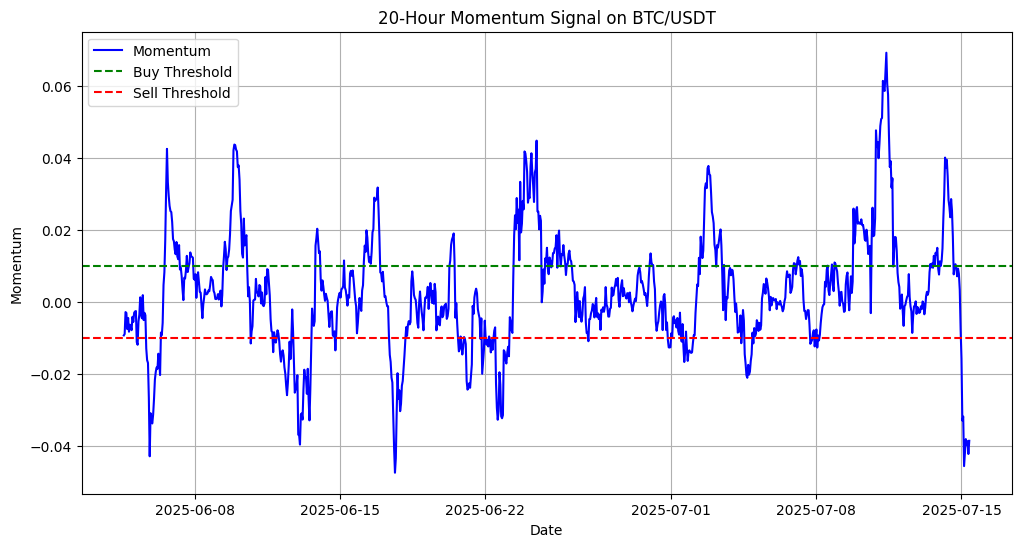

In [4]:
lookback = 20

df['momentum'] = df['Close'].pct_change(lookback)

plt.figure(figsize=(12, 6))
plt.plot(df.index[lookback:], df['momentum'].dropna(), label='Momentum', color='blue')
plt.axhline(y=0.01, color='green', linestyle='--', label='Buy Threshold')
plt.axhline(y=-0.01, color='red', linestyle='--', label='Sell Threshold')
plt.title(f'{lookback}-Hour Momentum Signal on BTC/USDT')
plt.xlabel('Date')
plt.ylabel('Momentum')
plt.legend()
plt.grid(True)
plt.show()


Now we plotted, starting from the first of june up until now, how the momentul is changing each they as well as plotted the threshholds for buying and selling.

We will also plot the asset data.

C:\Users\mitko\AppData\Local\Programs\Python\Python310\lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


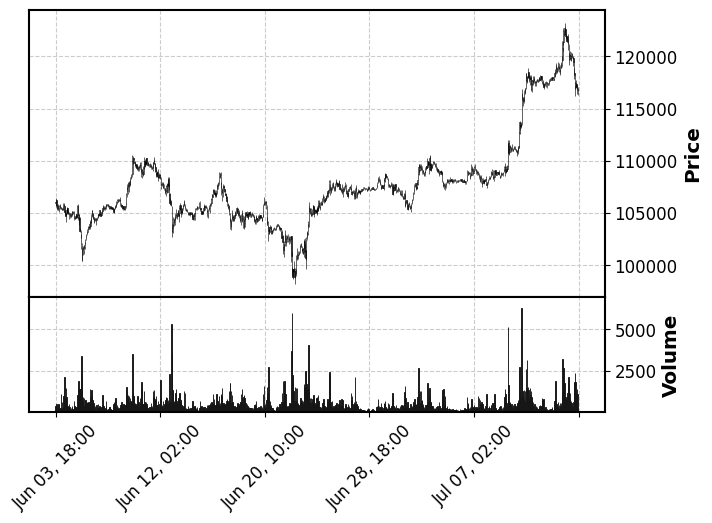

In [5]:

mpf.plot(df, type='candle', volume=True, style='classic')

plt.show()

Now that we can visually see we can go forward and try to do simple backtesting. Before that I will rename the columns for conviniency.

In [6]:
df.rename(columns={
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Volume': 'volume'
}, inplace=True)

Let us create a datafeed.

In [7]:
datafeed = bt.feeds.PandasData(dataname=df)

In [8]:
INITIAL_CASH = 10000
cerebro = bt.Cerebro()

cerebro.addstrategy(MomentumStrategy, lookback=20, threshold=0.02, trade_size=0.1) # We also can adjust the params here.

cerebro.adddata(datafeed)

cerebro.broker.setcash(INITIAL_CASH)

# I am not going to set commission since we assume that we are trading in a firm and have no commissions.
results = cerebro.run()

In [9]:
print(f"Final Portfolio Value: {cerebro.broker.getvalue():.2f}")

Final Portfolio Value: 10141.35


I want to notice that I used to get a value 10000 for the portfolio. Therefore no trades were made. We have not bought, our position stays at zero, we can not sell. Where is this problem coming from? After some observation we can notice that we are using ```size = int((self.broker.getvalue() * self.p.trade_size) / close_price)``` which returns 0 if the value is less than 0. Since we are buyin Bitcoins, we are never buying more than 1 bitcoin at a time. After removing the parsing to int the problem is no longer there.

Okey, we got a result and we see that we have increased our portfolio with not too many dollars. It is a possitive increase but not hing impresive. Let us analyze some more this result before moving to improvements.

I will add analyzers, do backtesting and also plot the equity curve, showing how our portfolio grows with time. Later on I will take the backtesting in a function for conviniency

In [10]:
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name='sharpe', timeframe=bt.TimeFrame.Days)
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')

In [11]:
results = cerebro.run()
strat = results[0]


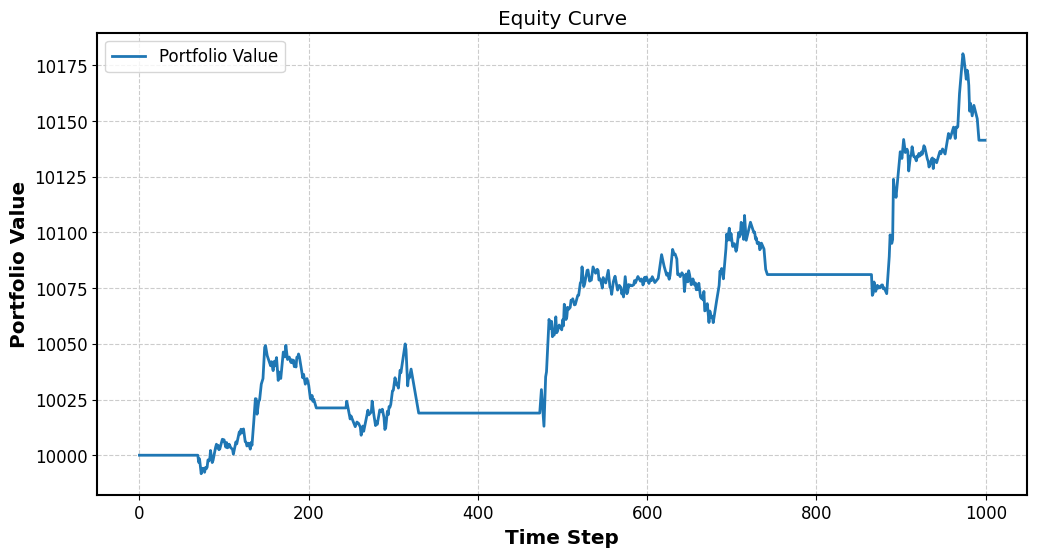

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(strat.equity_curve, label='Portfolio Value')
plt.title('Equity Curve')
plt.xlabel('Time Step')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()


In [13]:

trade_stats = strat.analyzers.trades.get_analysis()

# Total trades
total_trades = trade_stats.total.total
open_trades = trade_stats.total.open
closed_trades = trade_stats.total.closed

# Wins and losses
won = trade_stats.won.total
lost = trade_stats.lost.total

# PnL
total_net_pnl = trade_stats.pnl.net.total
average_net_pnl = trade_stats.pnl.net.average

print(f"Total trades: {total_trades}")
print(f"Open trades: {open_trades}")
print(f"Closed trades: {closed_trades}")
print(f"Winning trades: {won}")
print(f"Losing trades: {lost}")
print(f"Total Net PnL: {total_net_pnl:.2f}")
print(f"Average Net PnL: {average_net_pnl:.2f}")

Total trades: 4
Open trades: 0
Closed trades: 4
Winning trades: 3
Losing trades: 1
Total Net PnL: 141.35
Average Net PnL: 35.34


In [14]:
sharpe = strat.analyzers.sharpe.get_analysis()
drawdown = strat.analyzers.drawdown.get_analysis()

print("Sharpe Ratio:", sharpe.get('sharperatio', 'N/A'))
print(f"Max Drawdown: {drawdown.drawdown:.2f}%")
print(f"Drawdown Duration: {drawdown.len} bars")

Sharpe Ratio: 3.257710654996289
Max Drawdown: 0.38%
Drawdown Duration: 26 bars


### Improving the simple model
Based on the information above, we can conclude that our model functions but is far from optimal. Next, we will work on making it more complex and improving its performance. The first thing that might come to mind is how we actually decide on the hyperparameters we are using such as the threshhold and the trade size. There are a couple approaches when it comes to choosing those:


- **Grid Search**  
  Try all combinations of discrete values

- **Random Search**  
  Randomly sample combinations from the hyperparameter space

- **Bayesian Optimization**  
  Use prior evaluations to guide the search (e.g., maximize Sharpe ratio)

- **Walk-Forward Optimization**  
  1. Train on time window $$[t, t+k]$$  
  2. Test on $$[t+k+1, t+2k]$$  
  3. Slide the window forward


Before implementing GridSearch, we should ensure that the parameter values are not chosen arbitrarily, but are instead grounded in reasonable assumptions and sound trading principles. For instance, a trade size of 0.3 or 0.4 is clearly unreasonable, as it allocates a disproportionately large portion of the capital to a single trade, which significantly increases risk.

In [15]:
class BinanceData(bt.feeds.PandasData):
    params = (
        ('datetime', None),
        ('open', 'Open'),
        ('high', 'High'),
        ('low', 'Low'),
        ('close', 'Close'),
        ('volume', 'Volume'),
        ('openinterest', -1),
    )
lookbacks = [10, 20, 50]
thresholds = [0.005, 0.01, 0.02]
trade_sizes = np.arange(0.01,0.1,0.01)

results = []

for lookback, threshold, trade_size in itertools.product(lookbacks, thresholds, trade_sizes):
    cerebro = bt.Cerebro()
    cerebro.addstrategy(MomentumStrategy,
                        lookback=lookback,
                        threshold=threshold,
                        trade_size=trade_size)
    
    data = BinanceData(dataname=df)
    cerebro.adddata(data)

    cerebro.broker.setcash(10000)
    cerebro.broker.setcommission(commission=0)
    cerebro.run()

    final_value = cerebro.broker.getvalue()
    results.append({
        'lookback': lookback,
        'threshold': threshold,
        'trade_size': trade_size,
        'final_value': final_value
    })
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='final_value', ascending=False)

print(" Top Results:")
print(results_df.head())

 Top Results:
    lookback  threshold  trade_size   final_value
26        10       0.02        0.09  10158.160395
17        10       0.01        0.09  10157.837282
25        10       0.02        0.08  10140.602413
16        10       0.01        0.08  10140.237894
44        20       0.01        0.09  10129.777836


What we did here was to create a custom class BinanceData mapping some info. Then we choose 90 different combinations of hyperparamethers, tried each, ran a backtest and showed the best results.

## Momentum with SMA

If we make the trade size bigger we will notice that we can increase the final value, however this comes with a lot of risk. For now we will leave that and do something else. **Our model is still extremely simply and we are going to make it a bit more complex.** I am going to try and implement a **SMA crossover.** For this purpose I will
- Define short-term and long-term SMAs  
- Generate **buy signals** when the short SMA crosses above the long SMA  
- Generate **sell signals** when the short SMA crosses below the long SMA

Let's add this to our model.

In [16]:

class MomentumStrategyWithSMA(bt.Strategy):
    params = (
        ('lookback', 20),
        ('threshold', 0.01),
        ('trade_size', 0.1),
        ('sma_fast_period', 10),  
        ('sma_slow_period', 30), 
    )
    
    def __init__(self):
        self.sma_fast = bt.indicators.SimpleMovingAverage(self.data.close, period=self.p.sma_fast_period)
        self.sma_slow = bt.indicators.SimpleMovingAverage(self.data.close, period=self.p.sma_slow_period)
        self.crossover = bt.indicators.CrossOver(self.sma_fast, self.sma_slow)  # +1 when fast crosses above slow, -1 when below
    
    def next(self):
        if len(self.data) < max(self.p.lookback, self.p.sma_slow_period):
            return 

        momentum = (self.data.close[0] / self.data.close[-self.p.lookback]) - 1
        size = (self.broker.getvalue() * self.p.trade_size) / self.data.close[0]

       
        if momentum < -self.p.threshold and self.position.size > 0 and self.crossover < 0:
            self.close()

        
        elif momentum > self.p.threshold and not self.position and self.crossover > 0:
            if size > 0:
                self.buy(size=size)
            else:
                print("Calculated size too small to buy")


Since we will be running a lot of backtests, it might be a good idea to take it into a function

In [17]:
def run_backtest(strategy_class, data, initial_cash=10000, commission=0, **strategy_params):
    cerebro = bt.Cerebro()
    cerebro.addstrategy(strategy_class, **strategy_params)
    cerebro.adddata(data)
    cerebro.broker.setcash(initial_cash)
    cerebro.broker.setcommission(commission=commission)

    # Add analyzers
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')
    cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name='sharpe', timeframe=bt.TimeFrame.Days)
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')

    results = cerebro.run()
    strat = results[0]

    trade_stats = strat.analyzers.trades.get_analysis()
    sharpe = strat.analyzers.sharpe.get_analysis()
    drawdown = strat.analyzers.drawdown.get_analysis()

    stats = {
        'final_value': cerebro.broker.getvalue(),
        'total_trades': trade_stats.get('total', {}).get('total', 0),
        'won': trade_stats.get('won', {}).get('total', 0),
        'lost': trade_stats.get('lost', {}).get('total', 0),
        'pnl_total': trade_stats.get('pnl', {}).get('net', {}).get('total', 0),
        'pnl_avg': trade_stats.get('pnl', {}).get('net', {}).get('average', 0),
        'sharpe': sharpe.get('sharperatio', 'N/A'),
        'max_drawdown': drawdown.drawdown,
        'drawdown_duration': drawdown.len
    }

    return strat, stats


Having that I am going to run backtests on both strategies to see results

In [18]:
strat1, stats1 = run_backtest(MomentumStrategy,datafeed, lookback=20, threshold=0.01, trade_size=0.1)
strat2, stats2 = run_backtest(MomentumStrategyWithSMA,datafeed, lookback=20, threshold=0.01, trade_size=0.1, sma_fast_period=10, sma_slow_period=50)

In [19]:
pp = pprint.PrettyPrinter(indent=2)

print("Stats for MomentumStrategy:")
pp.pprint(stats1)

print("\nStats for MomentumStrategyWithSMA:")
pp.pprint(stats2)


Stats for MomentumStrategy:
{ 'drawdown_duration': 26,
  'final_value': 10144.229391833518,
  'lost': 5,
  'max_drawdown': 0.2932944354914176,
  'pnl_avg': 16.025487981501747,
  'pnl_total': 144.22939183351573,
  'sharpe': 3.4854173644042232,
  'total_trades': 9,
  'won': 4}

Stats for MomentumStrategyWithSMA:
{ 'drawdown_duration': 284,
  'final_value': 10078.236038318271,
  'lost': 0,
  'max_drawdown': 0.12274958684236169,
  'pnl_avg': 39.11801915913598,
  'pnl_total': 78.23603831827197,
  'sharpe': 1.8587250313980614,
  'total_trades': 2,
  'won': 2}


In [20]:
def grid_search_strategy(strategy_class, param_grid, data_df, initial_cash=10000, commission=0):
    keys, values = zip(*param_grid.items())
    param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

    results = []
    total_runs = len(param_combinations)
    print(f"Total backtests to run: {total_runs}")

    for i, params in enumerate(param_combinations):
        if 'sma_fast_period' in params and 'sma_slow_period' in params:
            if params['sma_fast_period'] >= params['sma_slow_period']:
                continue

        if (i + 1) % 10 == 0 or i == 0 or i == total_runs - 1:
            print(f"Running backtest {i + 1}/{total_runs} with params: {params}")

        data = bt.feeds.PandasData(dataname=data_df)

        strat, stats = run_backtest(strategy_class, data,
                                    initial_cash=initial_cash,
                                    commission=commission,
                                    **params)

        results.append({**params, **stats})

    results_df = pd.DataFrame(results).sort_values(by='final_value', ascending=False).reset_index(drop=True)
    return results_df


In [21]:
param_grid = {
    'lookback': [20, 50, 100],  
    'threshold': [ 0.01, 0.02, 0.03],
    'trade_size': [0.01, 0.05, 0.1],
    'sma_fast_period': [30, 20], 
    'sma_slow_period': [ 50, 100, 200], 
}
results_df = grid_search_strategy(MomentumStrategyWithSMA, param_grid, df)
print(results_df.head())

Total backtests to run: 162
Running backtest 1/162 with params: {'lookback': 20, 'threshold': 0.01, 'trade_size': 0.01, 'sma_fast_period': 30, 'sma_slow_period': 50}
Running backtest 10/162 with params: {'lookback': 20, 'threshold': 0.01, 'trade_size': 0.05, 'sma_fast_period': 20, 'sma_slow_period': 50}
Running backtest 20/162 with params: {'lookback': 20, 'threshold': 0.02, 'trade_size': 0.01, 'sma_fast_period': 30, 'sma_slow_period': 100}
Running backtest 30/162 with params: {'lookback': 20, 'threshold': 0.02, 'trade_size': 0.05, 'sma_fast_period': 20, 'sma_slow_period': 200}
Running backtest 40/162 with params: {'lookback': 20, 'threshold': 0.03, 'trade_size': 0.01, 'sma_fast_period': 20, 'sma_slow_period': 50}
Running backtest 50/162 with params: {'lookback': 20, 'threshold': 0.03, 'trade_size': 0.1, 'sma_fast_period': 30, 'sma_slow_period': 100}
Running backtest 60/162 with params: {'lookback': 50, 'threshold': 0.01, 'trade_size': 0.01, 'sma_fast_period': 20, 'sma_slow_period': 20

The insights we get from that are extremely valiable. 
- Firstly we execute little to no trades. This means that the information could be missleading.
- Secondly, although the sharpe ration is good, we have not met one of the **assumptions** it has - following a normal distribuution.

Probably the best thing we could do right now is to try and extend the period of our data since we are only using the last 1000 hours.

In [22]:


client = Client()


def fetch_hourly_data(symbol="BTCUSDT", years=3):
    interval = Client.KLINE_INTERVAL_1HOUR
    end_time = datetime.utcnow()
    start_time = end_time - timedelta(days=365 * years)
    
    df_list = []
    while start_time < end_time:
        # Convert to string
        start_str = start_time.strftime("%d %b %Y %H:%M:%S")
        try:
            klines = client.get_historical_klines(symbol, interval, start_str, limit=1000)
            if not klines:
                break
            
            temp_df = pd.DataFrame(klines, columns=[
                'Open time', 'Open', 'High', 'Low', 'Close', 'Volume',
                'Close time', 'Quote asset volume', 'Number of trades',
                'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore'])

            temp_df['Open time'] = pd.to_datetime(temp_df['Open time'], unit='ms')
            temp_df['Close time'] = pd.to_datetime(temp_df['Close time'], unit='ms')
            temp_df = temp_df[['Open time', 'Open', 'High', 'Low', 'Close', 'Volume']]
            temp_df[['Open', 'High', 'Low', 'Close', 'Volume']] = temp_df[['Open', 'High', 'Low', 'Close', 'Volume']].astype(float)
            df_list.append(temp_df)

            # Step forward 1000 hours
            start_time = temp_df['Open time'].iloc[-1] + timedelta(hours=1)
            time.sleep(0.5)  # Respect API rate limits
        except Exception as e:
            print("Error:", e)
            time.sleep(1)
    
    full_df = pd.concat(df_list).set_index('Open time')
    return full_df

# Fetch 3 years of data
df_2 = fetch_hourly_data(years=3)

print(df.head())
print(df.tail())
print(f"Total candles: {len(df_2)}")


                          open       high        low      close     volume  \
Open time                                                                    
2025-06-03 18:00:00  105943.99  106047.62  105592.17  106013.15  412.44980   
2025-06-03 19:00:00  106013.15  106428.58  106013.15  106238.81  403.87736   
2025-06-03 20:00:00  106238.81  106254.92  105353.50  105738.69  512.78907   
2025-06-03 21:00:00  105738.70  105847.71  105274.95  105367.93  366.43282   
2025-06-03 22:00:00  105367.92  105902.93  105308.00  105743.74  299.07218   

                     momentum  
Open time                      
2025-06-03 18:00:00       NaN  
2025-06-03 19:00:00       NaN  
2025-06-03 20:00:00       NaN  
2025-06-03 21:00:00       NaN  
2025-06-03 22:00:00       NaN  
                          open       high        low      close      volume  \
Open time                                                                     
2025-07-15 05:00:00  117480.48  117765.40  116962.97  117335.12  1161.2

C:\Users\mitko\AppData\Local\Programs\Python\Python310\lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


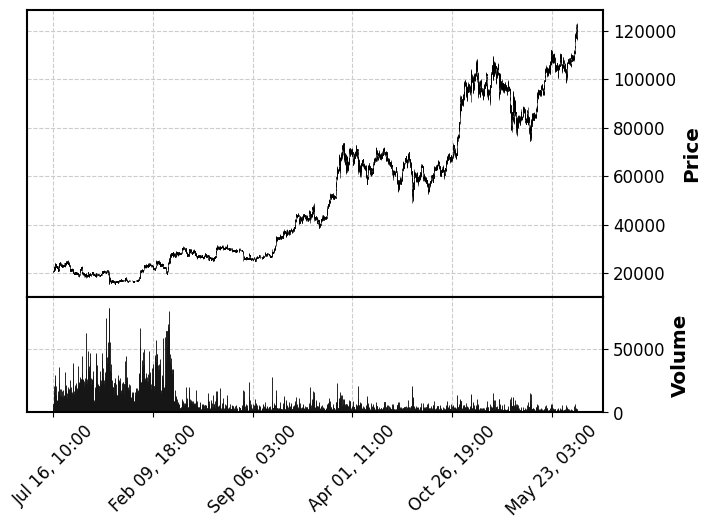

In [23]:

mpf.plot(df_2, type='candle', volume=True, style='classic')

plt.show()

Now lets run the tests we had but on the new data

In [24]:
datafeed_2 = bt.feeds.PandasData(dataname=df_2)

In [25]:

strat1, stats1 = run_backtest(MomentumStrategy,datafeed_2, lookback=20, threshold=0.01, trade_size=0.1)
strat2, stats2 = run_backtest(MomentumStrategyWithSMA,datafeed_2, lookback=100, threshold=0.01, trade_size=0.1, sma_fast_period=50, sma_slow_period=168)

pp = pprint.PrettyPrinter(indent=2)

print("Stats for MomentumStrategy with feed2:")
pp.pprint(stats1)

print("\nStats for MomentumStrategyWithSMA with feed2:")
pp.pprint(stats2)


Stats for MomentumStrategy with feed2:
{ 'drawdown_duration': 5642,
  'final_value': 11465.180774572085,
  'lost': 237,
  'max_drawdown': 1.4424531302533692,
  'pnl_avg': 3.9280985913460587,
  'pnl_total': 1465.1807745720798,
  'sharpe': 0.72297128941847,
  'total_trades': 373,
  'won': 136}

Stats for MomentumStrategyWithSMA with feed2:
{ 'drawdown_duration': 5035,
  'final_value': 11393.300350720765,
  'lost': 29,
  'max_drawdown': 1.26922302159014,
  'pnl_avg': 29.178264281521674,
  'pnl_total': 1313.0218926684754,
  'sharpe': 0.6670148392140827,
  'total_trades': 46,
  'won': 16}


We see that the base momentum strategy slightly outperforms in final value and total profit, but the SMA version achieves much higher profit per trade - meaning it's more selective and efficient. In conclusion, while both strategies yield similar overall returns, the MomentumStrategy operates with a high number of trades and higher drawdown, achieving slightly better final value and Sharpe ratio. In contrast, the MomentumStrategyWithSMA takes significantly fewer trades with a much higher average profit per trade and lower drawdown, indicating better trade efficiency and reduced risk. This makes the SMA-enhanced version more robust and stable, especially in environments where capital preservation and lower volatility are prioritized.

## Momentum with stop-loss

The next thing that we shall try to include is a stop-loss. The idea behind this is to limit potential losses by automatically exiting a position once it reaches a predefined negative threshold. This helps to protect capital during adverse market movements and adds a risk management layer to the strategy. By incorporating a stop-loss, we aim to reduce drawdowns and improve the overall risk-adjusted performance, particularly during volatile or trending market conditions where the existing logic might otherwise hold onto losing positions for too long.

In [26]:


class MomentumStrategyWithSMAstopLoss(bt.Strategy):
    params = (
        ('lookback', 20),
        ('threshold', 0.01),
        ('trade_size', 0.1),
        ('sma_fast_period', 10),  
        ('sma_slow_period', 30), 
        ('stop_loss_pct', 0.02),  
    )
    
    def __init__(self):
        self.sma_fast = bt.indicators.SimpleMovingAverage(self.data.close, period=self.p.sma_fast_period)
        self.sma_slow = bt.indicators.SimpleMovingAverage(self.data.close, period=self.p.sma_slow_period)
        self.crossover = bt.indicators.CrossOver(self.sma_fast, self.sma_slow)  
        self.stop_price = None  

    def next(self):
        if len(self.data) < max(self.p.lookback, self.p.sma_slow_period):
            return  

        momentum = (self.data.close[0] / self.data.close[-self.p.lookback]) - 1
        size = (self.broker.getvalue() * self.p.trade_size) / self.data.close[0]

        # Check stop loss first
        if self.position.size > 0 and self.stop_price is not None:
            if self.data.close[0] <= self.stop_price:
                self.log(f'STOP LOSS TRIGGERED: Closing position at {self.data.close[0]:.2f}')
                self.close()
                self.stop_price = None
                return 

        
        if momentum < -self.p.threshold and self.position.size > 0 and self.crossover < 0:
            self.log(f'SELL signal: Closing position at {self.data.close[0]:.2f}')
            self.close()
            self.stop_price = None

      
        elif momentum > self.p.threshold and not self.position and self.crossover > 0:
            if size > 0:
                self.buy(size=size)
                # Set stop loss price after buying
                self.stop_price = self.data.close[0] * (1 - self.p.stop_loss_pct)
                self.log(f'BUY signal: Buying at {self.data.close[0]:.2f} with stop loss at {self.stop_price:.2f}')
            else:
                print("Calculated size too small to buy")

    def log(self, txt):
        dt = self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()} - {txt}')


In [27]:
strat, stats = run_backtest(MomentumStrategyWithSMAstopLoss,datafeed_2, lookback=100, threshold=0.01, trade_size=0.1, sma_fast_period=50, sma_slow_period=250)

pp = pprint.PrettyPrinter(indent=2)

pp.pprint(stats)

2022-07-29 - BUY signal: Buying at 23880.60 with stop loss at 23402.99
2022-07-31 - STOP LOSS TRIGGERED: Closing position at 23377.48
2022-08-08 - BUY signal: Buying at 23964.99 with stop loss at 23485.69
2022-08-09 - STOP LOSS TRIGGERED: Closing position at 23472.62
2022-09-09 - BUY signal: Buying at 21291.62 with stop loss at 20865.79
2022-09-13 - STOP LOSS TRIGGERED: Closing position at 20829.77
2022-09-27 - BUY signal: Buying at 20229.26 with stop loss at 19824.67
2022-09-27 - STOP LOSS TRIGGERED: Closing position at 19110.79
2022-10-03 - BUY signal: Buying at 19611.65 with stop loss at 19219.42
2022-10-09 - SELL signal: Closing position at 19401.97
2022-10-18 - BUY signal: Buying at 19596.34 with stop loss at 19204.41
2022-10-19 - STOP LOSS TRIGGERED: Closing position at 19190.20
2022-11-05 - BUY signal: Buying at 21387.53 with stop loss at 20959.78
2022-11-06 - STOP LOSS TRIGGERED: Closing position at 20905.58
2022-11-30 - BUY signal: Buying at 16884.18 with stop loss at 16546.50

To manage risk using a stop-loss step, we observe that while the maximum drawdown decreases, the number of losing trades increases. This reflects a trade-off that must be considered. An alternative approach is to use the Average True Range (ATR), which adjusts the stop-loss dynamically based on market volatility. Additionally, techniques like Grid Search can be employed to optimize the stop-loss level based on historical performance.

# Dynamic position sizing
In this section, I will implement dynamic position sizing to improve trade management.

**More about the concept can be found in the notebook: Premise, research.ipynb**

We will use three core ideas to determine trade size more effectively:

- **Volatility Adjustment:** Reduce trade size in more volatile markets using ATR.

- **Conviction Score:** Increase size when both momentum and volume agree (strong signal).

- **Drawdown Awareness:** Reduce size after consecutive losses to protect capital.

In [28]:
class MomentumStrategyWithSMApositionSizing(bt.Strategy):
    params = (
        ('lookback', 20),
        ('threshold', 0.01),
        ('trade_size', 0.1),
        ('sma_fast_period', 10),
        ('sma_slow_period', 30),
        ('atr_period', 14),
    )

    def __init__(self):
        self.sma_fast = bt.indicators.SimpleMovingAverage(self.data.close, period=self.p.sma_fast_period)
        self.sma_slow = bt.indicators.SimpleMovingAverage(self.data.close, period=self.p.sma_slow_period)
        self.crossover = bt.indicators.CrossOver(self.sma_fast, self.sma_slow)
        self.atr = bt.indicators.ATR(self.data, period=self.p.atr_period)
        self.buy_signals = []
        self.sell_signals = []
        self.equity_curve = []  # track portfolio value over time

        self.max_equity = None  # track max equity for drawdown adjustment

    def next(self):
        # Record equity at each step
        self.equity_curve.append(self.broker.getvalue())

        if len(self.data) < max(self.p.lookback, self.p.sma_slow_period, self.p.atr_period):
            return

        momentum = (self.data.close[0] / self.data.close[-self.p.lookback]) - 1

        # Base size
        size = (self.broker.getvalue() * self.p.trade_size) / self.data.close[0]

        # ATR-based volatility adjustment
        atr = self.atr[0]
        if atr > 0:
            size /= (1 + atr / self.data.close[0])

        # Conviction score
        momentum_score = max(0, (momentum - self.p.threshold)) * 100  # scaled
        volume_mean = sum(self.data.volume.get(size=self.p.lookback, ago=-1)) / self.p.lookback
        volume_score = self.data.volume[0] / volume_mean if volume_mean > 0 else 1
        conviction_multiplier = min(momentum_score * volume_score, 2.0)
        size *= conviction_multiplier

        # Drawdown-aware size reduction
        current_equity = self.broker.getvalue()
        if self.max_equity is None or current_equity > self.max_equity:
            self.max_equity = current_equity
        drawdown = (self.max_equity - current_equity) / self.max_equity
        if drawdown > 0.05:
            size *= max(0.5, 1 - drawdown * 2)

        # Trading logic
        if momentum < -self.p.threshold and self.position.size > 0 and self.crossover < 0:
            self.close()
            self.sell_signals.append((self.data.datetime.datetime(0), self.data.close[0]))

        elif momentum > self.p.threshold and not self.position and self.crossover > 0:
            if size > 0:
                self.buy(size=size)
                self.buy_signals.append((self.data.datetime.datetime(0), self.data.close[0]))
            else:
                print("Calculated size too small to buy")


### Note on Risk Management

In this implementation, no explicit stop-loss mechanism is used. Instead, the strategy employs adaptive position sizing to mitigate risk. When market conditions deteriorate - such as during increased volatility, weakening momentum, or account drawdowns - the size of new trades is systematically reduced.

This approach serves as a soft alternative to traditional stop-losses, as it minimizes capital at risk during unfavorable conditions without prematurely exiting positions. However, this method does not preclude the use of stop-losses; both techniques can be combined to create a layered risk management framework that balances flexibility with protective constraints.

In [29]:
strat, stats = stratPositionSizing = run_backtest(MomentumStrategyWithSMApositionSizing,datafeed_2, lookback=200, threshold=0.01, trade_size=0.1, sma_fast_period=50, sma_slow_period=350)

pp = pprint.PrettyPrinter(indent=2)

pp.pprint(stats)

{ 'drawdown_duration': 1302,
  'final_value': 11482.516207270433,
  'lost': 13,
  'max_drawdown': 1.5910716166562457,
  'pnl_avg': 74.12581036352178,
  'pnl_total': 1482.5162072704356,
  'sharpe': 0.4282204178641853,
  'total_trades': 20,
  'won': 7}


## Printing buy/sell plot
Now if we want we could print a graph and show when buys and sells are executed using the signal lists.

C:\Users\mitko\AppData\Local\Programs\Python\Python310\lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


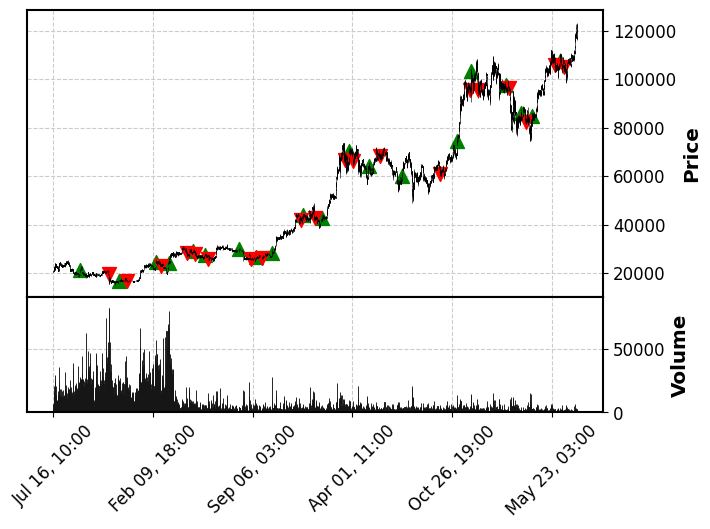

In [30]:

df_2['Buy'] = float('nan')
df_2['Sell'] = float('nan')


for buy_dt, buy_price in strat.buy_signals:
    if buy_dt in df_2.index:
        df_2.at[buy_dt, 'Buy'] = buy_price

for sell_dt, sell_price in strat.sell_signals:
    if sell_dt in df_2.index:
        df_2.at[sell_dt, 'Sell'] = sell_price

ap = [
    mpf.make_addplot(df_2['Buy'], type='scatter', markersize=100, marker='^', color='g'),
    mpf.make_addplot(df_2['Sell'], type='scatter', markersize=100, marker='v', color='r'),
]

mpf.plot(df_2, type='candle', volume=True, style='classic', addplot=ap)
plt.show()


We plotted the last three years of price data along with the points where we bought and sold. As expected, the strategy tends to sell more frequently than it buys. This aligns with the strategy’s design, which favors taking fewer but higher-quality trades rather than holding positions that lack strong conviction.

However, the plot also reveals some shortcomings: there are instances where it would have been reasonable to sell, yet the strategy held the stock. Conversely, there are moments when the strategy exited positions prematurely due to being misled by short, sharp drops in momentum or SMA signals. These rapid but temporary fluctuations caused the algorithm to sell when it might have been better to maintain the position.



## Performing grid-search

In [31]:
param_grid = {
    'lookback': [20, 50],
    'threshold': [0.01, 0.02],
    'trade_size': [0.05, 0.1],
    'sma_fast_period': [20],
    'sma_slow_period': [50, 100],
    'atr_period': [14],
}

#### Note
I am not using many parameters since each backtesting for the df_2 data takes a lot of time

In [32]:
results_df = grid_search_strategy(MomentumStrategyWithSMApositionSizing, param_grid, df_2)
print(results_df.head())

Total backtests to run: 16
Running backtest 1/16 with params: {'lookback': 20, 'threshold': 0.01, 'trade_size': 0.05, 'sma_fast_period': 20, 'sma_slow_period': 50, 'atr_period': 14}
Running backtest 10/16 with params: {'lookback': 50, 'threshold': 0.01, 'trade_size': 0.05, 'sma_fast_period': 20, 'sma_slow_period': 100, 'atr_period': 14}
Running backtest 16/16 with params: {'lookback': 50, 'threshold': 0.02, 'trade_size': 0.1, 'sma_fast_period': 20, 'sma_slow_period': 100, 'atr_period': 14}
   lookback  threshold  trade_size  sma_fast_period  sma_slow_period  \
0        50       0.02        0.10               20               50   
1        50       0.01        0.10               20               50   
2        50       0.02        0.05               20               50   
3        50       0.01        0.05               20               50   
4        20       0.02        0.10               20              100   

   atr_period   final_value  total_trades  won  lost    pnl_total     pn

Here we have only tried 16 combinations but with enough computational power we could increase them significantly. After all that we could see that we can make a good net profit. Let us take for example a strategy with a return of 13500 and start of 10000:
#### Annualized Return Calculation

We assume an initial investment of \\$10,000 that grows to \\$13,500 over 3 years.

To compute the average annual return, we use the **Compound Annual Growth Rate (CAGR)** formula:

$$
\text{CAGR} = \left( \frac{V_f}{V_i} \right)^{\frac{1}{n}} - 1
$$

Where:
- $ V_f = 13,500 $ is the final value,
- $ V_i = 10,000 $ is the initial value,
- $ n = 3 $ years.

Substituting in the values:

$$
\text{CAGR} = \left( \frac{13,500}{10,000} \right)^{\frac{1}{3}} - 1 = (1.35)^{\frac{1}{3}} - 1 \approx 0.1057
$$

So the **annualized return is approximately 10.57% per year**.


However, there is another concern to address in this situation. Even though we may have found a strategy with a winning rate that **outperforms benchmarks like the S&P 500, bonds, or even traditional banks**, we must be cautious.

The danger lies in the fact that we may simply be **adapting to the asset's historical behavior**, selecting only the parameter combinations that *happen to have worked well* - not because of sound logic, but by chance. This might be overfitting and might perform bad on unseen data.

If we were dealing with a machine learning problem **we would approach this using k-fold cross validation and test train splits.** However since we are working with time series the solution to this problem will require other methods. We could use **Time series cross-validation:**
- **Expanding window:** You increase the training size with each fold.

- **Rolling window:** Keep training window size fixed and roll it forward.

- **Walk-forward validation**
    - You **retrain the model at each step** using the latest available data.
    - Each forecast is made for **a single time point** or **a small forecast horizon**.



For the sake of time, I will implement only one of the following strategies, acknowledging that more could be explored and the best one chosen based on the specific asset.

### Implementing Time series cross validation

In this section I will try to implement a time series cross validation with grid search in order to **choose the best params while not overfitting the model.** Firstly we are going to import ```from sklearn.model_selection import TimeSeriesSplit.```

Now we will approach that in the following order:
1. **Define a grid of params**
2. **Define the cross-validation function**
3. **Run the grid search with cross validation**


In [33]:
param_grid = {
    'lookback': [20, 50],
    'threshold': [0.01, 0.02],
    'trade_size': [0.05, 0.1],
    'sma_fast_period': [10, 20],
    'sma_slow_period': [30, 50],
    'atr_period': [14],
}

param_combinations = list(product(*param_grid.values()))
param_names = list(param_grid.keys())

In [34]:
def cross_validate_strategy(df, strategy_cls, param_dict, n_splits=3):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    final_values = []

    for train_index, test_index in tscv.split(df):
        df_train = df.iloc[train_index].copy()
        df_test = df.iloc[test_index].copy()

        cerebro = bt.Cerebro()
        cerebro.addstrategy(strategy_cls, **param_dict)

        data = bt.feeds.PandasData(dataname=pd.concat([df_train, df_test])) # use full data so indicators work
        cerebro.adddata(data)

        cerebro.broker.setcash(10000)
        cerebro.broker.setcommission(commission=0)
        cerebro.run()

        final_values.append(cerebro.broker.getvalue())

    avg_value = sum(final_values) / len(final_values)
    return avg_value


In [35]:
type(results)

list

Now we are going to run the cross-validation which will take sometime becuase of the computational power needed. We are going to perfrom the ```cross_validation_strategy``` 32 times

In [36]:
results = []
counter = 1
for combo in param_combinations:
    print(counter)
    param_dict = dict(zip(param_names, combo))
    
    if param_dict['sma_fast_period'] >= param_dict['sma_slow_period']:
        continue

    avg_final_value = cross_validate_strategy(df_2, MomentumStrategyWithSMApositionSizing, param_dict)

    results.append({
        **param_dict,
        'avg_final_value': avg_final_value
    })
    counter+=1

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='avg_final_value', ascending=False)
print(results_df.head())


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
    lookback  threshold  trade_size  sma_fast_period  sma_slow_period  \
31        50       0.02        0.10               20               50   
23        50       0.01        0.10               20               50   
27        50       0.02        0.05               20               50   
4         20       0.01        0.10               10               30   
29        50       0.02        0.10               10               50   

    atr_period  avg_final_value  
31          14     12743.456107  
23          14     11954.300559  
27          14     11302.667182  
4           14     11263.032986  
29          14     10968.980039  


This function, however, takes some time to perform, since we not only have to test it on all the different hyperparameter combinations, but also do cross-validation on different time periods of the data. Nevertheless, this is not inherently bad, it is expected and even necessary to ensure that the strategy is robust and not overfitting to a specific period. Investing this computational effort helps us find hyperparameters that generalize well across various market conditions, ultimately leading to more reliable and consistent performance in live trading.

#### Note
We must also mention that for parameter optimization we could use Random Search or Bayesian Optimization in order to lower the computation time.

## Multiple assets evaluation

It is visible that we can keep modifying our algorithm by adding RSI or bollinger bands, etc. However, I will try to use the simple algorithm we have developed up until now and test it on more then one asset. 

**It is important to say that I am going to choose assets that are expected to have a momentum attitude. This could be considered p-hacking, but in our case it is not, since our model works on the assumption that the stock follows a momentum flow.**

In [37]:
symbols = ["NVDA", "MTUM", "BTC-USD", "ICLN", "SPMO","AAPL","AMD","TSLA","QQQ","IWM"]
data_dict = {}

for symbol in symbols:
    try:
        df = yf.download(symbol, period="3y", interval="1d")
        data_dict[symbol] = df
        print(f"Fetched data for {symbol}")
    except Exception as e:
        print(f"Error fetching {symbol}: {e}")

C:\Users\mitko\AppData\Local\Temp\ipykernel_19452\3835241949.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, period="3y", interval="1d")
[*********************100%***********************]  1 of 1 completed
C:\Users\mitko\AppData\Local\Temp\ipykernel_19452\3835241949.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, period="3y", interval="1d")


Fetched data for NVDA


[*********************100%***********************]  1 of 1 completed
C:\Users\mitko\AppData\Local\Temp\ipykernel_19452\3835241949.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, period="3y", interval="1d")


Fetched data for MTUM


[*********************100%***********************]  1 of 1 completed
C:\Users\mitko\AppData\Local\Temp\ipykernel_19452\3835241949.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, period="3y", interval="1d")


Fetched data for BTC-USD


[*********************100%***********************]  1 of 1 completed
C:\Users\mitko\AppData\Local\Temp\ipykernel_19452\3835241949.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, period="3y", interval="1d")


Fetched data for ICLN


[*********************100%***********************]  1 of 1 completed
C:\Users\mitko\AppData\Local\Temp\ipykernel_19452\3835241949.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, period="3y", interval="1d")


Fetched data for SPMO


[*********************100%***********************]  1 of 1 completed
C:\Users\mitko\AppData\Local\Temp\ipykernel_19452\3835241949.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, period="3y", interval="1d")


Fetched data for AAPL


[*********************100%***********************]  1 of 1 completed
C:\Users\mitko\AppData\Local\Temp\ipykernel_19452\3835241949.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, period="3y", interval="1d")


Fetched data for AMD


[*********************100%***********************]  1 of 1 completed
C:\Users\mitko\AppData\Local\Temp\ipykernel_19452\3835241949.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, period="3y", interval="1d")


Fetched data for TSLA


[*********************100%***********************]  1 of 1 completed
C:\Users\mitko\AppData\Local\Temp\ipykernel_19452\3835241949.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, period="3y", interval="1d")


Fetched data for QQQ


[*********************100%***********************]  1 of 1 completed

Fetched data for IWM


I am fetching the data from Yahoo Finance since the Binance contains only crypto currency data

In [38]:
strategy_params = {
    'lookback': 20,
    'threshold': 0.01,
    'trade_size': 0.1,
    'sma_fast_period': 20,
    'sma_slow_period': 50,
    'atr_period': 14,
}


for symbol, df in data_dict.items():
    print(f"\nRunning backtest for {symbol}...")

    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    
    datafeed = bt.feeds.PandasData(dataname=df)

    
    strat, stats =run_backtest(MomentumStrategyWithSMApositionSizing, datafeed, **strategy_params)
    pp = pprint.PrettyPrinter(indent=2)
    pp.pprint(stats)




Running backtest for NVDA...
{ 'drawdown_duration': 266,
  'final_value': 14581.580279477737,
  'lost': 1,
  'max_drawdown': 3.1453986139543337,
  'pnl_avg': 813.0073203144336,
  'pnl_total': 4065.036601572168,
  'sharpe': 1.2501495295200957,
  'total_trades': 6,
  'won': 4}

Running backtest for MTUM...
{ 'drawdown_duration': 100,
  'final_value': 10320.001193702672,
  'lost': 5,
  'max_drawdown': 0.708544854889436,
  'pnl_avg': 17.465064721405245,
  'pnl_total': 122.25545304983672,
  'sharpe': 0.03628528980321749,
  'total_trades': 8,
  'won': 2}

Running backtest for BTC-USD...
{ 'drawdown_duration': 1,
  'final_value': 11806.17627681127,
  'lost': 6,
  'max_drawdown': 0.5072356284427612,
  'pnl_avg': 148.94923720078702,
  'pnl_total': 1638.4416092086574,
  'sharpe': 0.46870120188414194,
  'total_trades': 12,
  'won': 5}

Running backtest for ICLN...
{ 'drawdown_duration': 623,
  'final_value': 9802.714358597077,
  'lost': 6,
  'max_drawdown': 2.834951807682511,
  'pnl_avg': -73.28

Our strategy shows varied performance across different assets. NVDA and AMD demonstrate strong profitability with favorable Sharpe ratios and controlled drawdowns, indicating effective momentum capture. Conversely, ICLN struggles significantly with consistent losses and a negative Sharpe ratio. Overall, the strategy performs better on high-volume tech stocks and less effectively on some ETFs and sector-specific assets. Drawdown durations suggest the strategy generally recovers steadily, though some assets show prolonged periods of stagnation or risk exposure. 

But overall the strategy is winning. Although we take risk and there are moments of drawdown, we were able to obtain a positive tho mild Sharpe ration

**Also we see that our model has strict rules which allows only for little but more secure trades to be captured.**

##  Possible improvements
Up to this point, we were able to explore and implement various strategies, test our hypotheses with metrics and evaluations, and optimize for the best performance. However, building a working model that consistently outperforms funds and performs well across multiple assets is no easy task and requires a significant amount of time and effort. We started with a simple momentum-based model, then introduced SMA, attempted to add a stop-loss mechanism, performed a grid search for the best hyperparameters, tested the strategy on multiple assets, implemented dynamic position sizing, and visualized key performance data.

### Strategy Enhancements
- **Take-Profit Logic**
  - Introduce parameters to define TP thresholds.
  - Automatically close trades when the price crosses these levels.
- **Additional Technical Indicators**
  - Integrate more indicators such as:
    - Relative Strength Index (RSI)
    - MACD
    - Bollinger Bands
    - ADX
  - Combine indicators to form hybrid strategies.

###  Evaluation & Metrics
- **Risk-Adjusted Return Metrics**
  - Include metrics like:
    - Sortino Ratio
    - Calmar Ratio
    - Profit Factor
    - Maximum consecutive losses/wins

###  Optimization Improvements
- **Walk-Forward Optimization**
  - Train on one part of the data and test on the next, iteratively.
  - Helps test robustness over changing market conditions.
- **Early stopping in Grid search**
  - Abort parameter sets that perform poorly in the first segment of the backtest.



### Resources 
- https://medium.com/funny-ai-quant/momentum-based-strategy-optimization-with-grid-search-on-backtrader-8c0d6cd1cc36
- https://www.a1trading.com/how-to-calculate-the-right-lot-size-for-forex-trading/#:~:text=To%20calculate%20the%20correct%20lot%20size%20for%20a,away%20is%20your%20stop%20loss%20from%20your%20entry%3F
- https://quantstrattrader.com/2016/01/13/on-the-relationship-between-the-sma-and-momentum/
- https://www.investopedia.com/terms/s/stop-lossorder.asp#:~:text=Traders%20can%20control%20their%20exposure%20to%20risk%20by,a%20certain%20price%20known%20as%20the%20stop%20price.